<!-- -->

# Basic Spatial Analysis

## Description

This notebook presents a sample workflow of spatial data processing using vector data and raster data loaded from the Planetary Computer STAC catalog. Our aim in this notebook is to calculate a time series of remote sensing indices for a study area and plot the results.

***

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray as rio
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

from pystac_client import Client
import planetary_computer as pc
from odc.stac import stac_load

# Set config for displaying tables nicely
# !! OTHERWISE !! parts of longer infos won't be displayed in tables
pd.set_option("display.max_colwidth", 200)
pd.set_option("display.max_rows", None)

In [ ]:
# In the STAC workflow we select a collection explicitly when searching the catalog below.

,name,description,license,default_crs,default_resolution
name,,,,,
cop_dem_glo_30,cop_dem_glo_30,Copernicus DEM 30 m,None,None,None
landsat_etm_c2_l2,landsat_etm_c2_l2,Landsat Level 2 Collection 2 data acquired by the Enhanced Thematic Mapper onboard Landsat 7,CC-BY-4.0,None,None
landsat_ot_c2_l2,landsat_ot_c2_l2,Landsat Level 2 Collection 2 data acquired by the Operational Land Imager and Thermal Infrared Sensor onboard Landsat 8 and 9,CC-BY-4.0,None,None
meteo_demmin,meteo_demmin,Meteorological parameters for the Agrisens Project,None,None,None
s2_c1_l2a,s2_c1_l2a,The Sentinel-2 program provides global imagery in thirteen spectral bands at 10m-60m resolution and a revisit time of approximately five days. This dataset represents the global Sentinel-2 archive...,None,None,None
s2_l2a,s2_l2a,"Sentinel-2a and Sentinel-2b imagery, processed to Level 2A (Surface Reflectance) and converted to Cloud Optimized GeoTIFFs",None,None,None
s2_vi,s2_vi,Vegetation indices derived from Sentinel-2A/B,None,None,None
sentinel1_coherence,sentinel1_coherence,Sentinel-1A/B SAR Coherence,None,None,None
sentinel1_h2a,sentinel1_h2a,Sentinel-1A/B SAR Dual-polarimetric decomposition scenes,None,None,None


### Load Datasets

Now, we load the data with `stac_load()` using the calculated spatial extent (bounding box) and the STAC search results.

In [ ]:
# Load data from Planetary Computer (STAC)
STAC_URL = "https://planetarycomputer.microsoft.com/api/stac/v1"
COLLECTION = "sentinel-2-l2a"

# Area of interest: Würzburg (EPSG:4326)
bbox = (9.88, 49.75, 10.0, 49.82)

# Output grid
crs = "EPSG:32632"
resolution = 20

# Search STAC items
catalog = Client.open(STAC_URL)

datetime = "2021-03-01/2021-06-15"
query = {"eo:cloud_cover": {"lt": 40}}

search = catalog.search(collections=[COLLECTION], bbox=bbox, datetime=datetime, query=query)
items = list(search.get_items())
len(items)

# Load pixels with odc-stac
bands = ["B02", "B03", "B04", "B08", "SCL"]
resampling = {"*": "bilinear", "SCL": "nearest"}

ds_raw = stac_load(
    items,
    bands=bands,
    crs=crs,
    resolution=resolution,
    groupby="solar_day",
    patch_url=pc.sign,
    dtype="uint16",
    nodata=0,
    resampling={"*": "bilinear", "SCL": "nearest"},
)

# Rename to match the variable names used throughout this notebook
rename_map = {"B02": "blue", "B03": "green", "B04": "red", "B08": "nir", "SCL": "scl"}
ds = ds_raw.rename({k: v for k, v in rename_map.items() if k in ds_raw.data_vars})

# Scale reflectance (Sentinel-2 L2A) to ~0..1
for name in list(ds.data_vars):
    if name != "scl":
        ds[name] = ds[name].astype("float32") * 1e-4

ds


### Calculating Seasonal Median
While we have data for every time step, some basic statistics for each season will be helpful for real applications. We can first group our raster data by season and then use the grouped data to compute the median value at the pixel level. It is achieved by using the `groupby()` function, following by a method (i.e. `median()`).

In xarray, the season is pre-categorized into `'DJF'` (Dec, Jan, Feb), `'MAM'` (Mar, Apr, May), `'JJA'` (June, July, Aug), and `'SON'` (Sep, Oct, Nov).

In [23]:
# Group by Season and Calculate the seasonal Median.
ds_grp = ds.where(ds.scl <= 6).groupby('time.season').median()
print(ds_grp)

<xarray.Dataset>
Dimensions:      (season: 4, y: 126, x: 113)
Coordinates:
  * y            (y) float64 1.557e+07 1.557e+07 ... 1.557e+07 1.557e+07
  * x            (x) float64 -2.945e+05 -2.944e+05 ... -2.911e+05 -2.911e+05
    spatial_ref  int32 32734
  * season       (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    red          (season, y, x) float32 1.583e+03 1.454e+03 ... 1.205e+03
    green        (season, y, x) float32 1.565e+03 1.481e+03 ... 1.277e+03
    blue         (season, y, x) float32 1.325e+03 1.282e+03 ... 1.176e+03
    nir          (season, y, x) float32 2.442e+03 2.724e+03 ... 3.235e+03
    nir08        (season, y, x) float32 2.434e+03 2.528e+03 ... 3.989e+03
    rededge2     (season, y, x) float32 2.143e+03 2.365e+03 ... 3.117e+03
    scl          (season, y, x) float32 5.0 5.0 5.0 5.0 5.0 ... 4.0 4.0 4.0 4.0
Attributes:
    crs:           EPSG:32734
    grid_mapping:  spatial_ref


### Calculate selected Remote Sensing Indices

Tasseled cap transformation is a common method for vegetation analysis. It transforms the spectral information of our data into multiple spectral indicators, including wetness, to derive the interrelationship between soil and canopy moisture, the soil brightness index (SBI), and the green vegetation index (GVI). They are calculated using RGB, as well as the NIR band. The formulas are shown below in the code:

***Tip: A database of remote sensing indices is available at [this site](https://www.indexdatabase.de/db/i-single.php?id=0).***

In [24]:
#NDVI
ndvi = (ds_grp.nir - ds_grp.red)/(ds_grp.nir+ds_grp.red)

# Tasseled Cap Wetness
wet = 0.1509*ds_grp.blue + 0.1973*ds_grp.green + 0.3279*ds_grp.red + 0.3406*ds_grp.nir - 0.711211 - 0.457212
# Tasseled Cap Green Vegetation
gvi = -0.2848*ds_grp.blue-0.2435*ds_grp.green-0.5436*ds_grp.red + 0.7243*ds_grp.nir + 0.084011 - 0.180012
# Tasseled Cap Soil Brightness
sbi = 0.332*ds_grp.green + 0.603*ds_grp.red + 0.675*ds_grp.rededge2 + 0.262*ds_grp.nir08

After calculating the indices, we can put them into our dataset using `assign()` function.

***(Note: we need to assign it back to ds_grp)***

Now, there are four new variables we just assigned in the `ds_grp` dataset.

In [25]:
# Add calculated indices into our Dataset
ds_grp = ds_grp.assign(ndvi=ndvi, wet=wet, gvi=gvi, sbi=sbi)

print(ds_grp)

<xarray.Dataset>
Dimensions:      (season: 4, y: 126, x: 113)
Coordinates:
  * y            (y) float64 1.557e+07 1.557e+07 ... 1.557e+07 1.557e+07
  * x            (x) float64 -2.945e+05 -2.944e+05 ... -2.911e+05 -2.911e+05
    spatial_ref  int32 32734
  * season       (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    red          (season, y, x) float32 1.583e+03 1.454e+03 ... 1.205e+03
    green        (season, y, x) float32 1.565e+03 1.481e+03 ... 1.277e+03
    blue         (season, y, x) float32 1.325e+03 1.282e+03 ... 1.176e+03
    nir          (season, y, x) float32 2.442e+03 2.724e+03 ... 3.235e+03
    nir08        (season, y, x) float32 2.434e+03 2.528e+03 ... 3.989e+03
    rededge2     (season, y, x) float32 2.143e+03 2.365e+03 ... 3.117e+03
    scl          (season, y, x) float32 5.0 5.0 5.0 5.0 5.0 ... 4.0 4.0 4.0 4.0
    ndvi         (season, y, x) float32 0.2134 0.304 0.2569 ... 0.5175 0.4572
    wet          (season, y, x) float32 1.858e+03 1.889e+03 ... 1.925e+

### Clip Dataset by Spatial Vector

We can clip the xarray Dataset with a specific geometry given the coordinate reference system to focus our analysis on the area of interest. It can be done using `clip()` function from the `rioxarray` library, which is handy for working with multidimensional datasets.

***Tip: We are using functions from the package `rioxarray`; the user documentation of this package is available at [this site](https://corteva.github.io/rioxarray/stable/index.html).***

In [ ]:
# Clip to AOI
# ds_clip = ds_grp.rio.clip(aoi_wgs.geometry, aoi_wgs.crs)
# print(ds_clip)

### Plot Time Series

After clipping the area, we can perform some basic analysis using our Tasseled cap indices to investigate the seasonal variations in 2019. First, we set up lists of seasons and colormaps. Then, we plot 4 * 4 subplots, followed by few lines of `plot()` inside a enumerate loop iterating over the seasons. `axes.flatten()` flatten the array into one dimension. By looping through it, we can set the title for every individual plot. Other layout options, including setting ticks and labels, can be done by looping through the `axes.flat`.

***Tip: robust=True can help to remove the outliners.***

***Tip: sns.set(font_scale) is a function from seaborn library to scale all texts with a single factor.***

Text(0.5, 1.02, 'Seasonal Median 2019 ~ 2020')

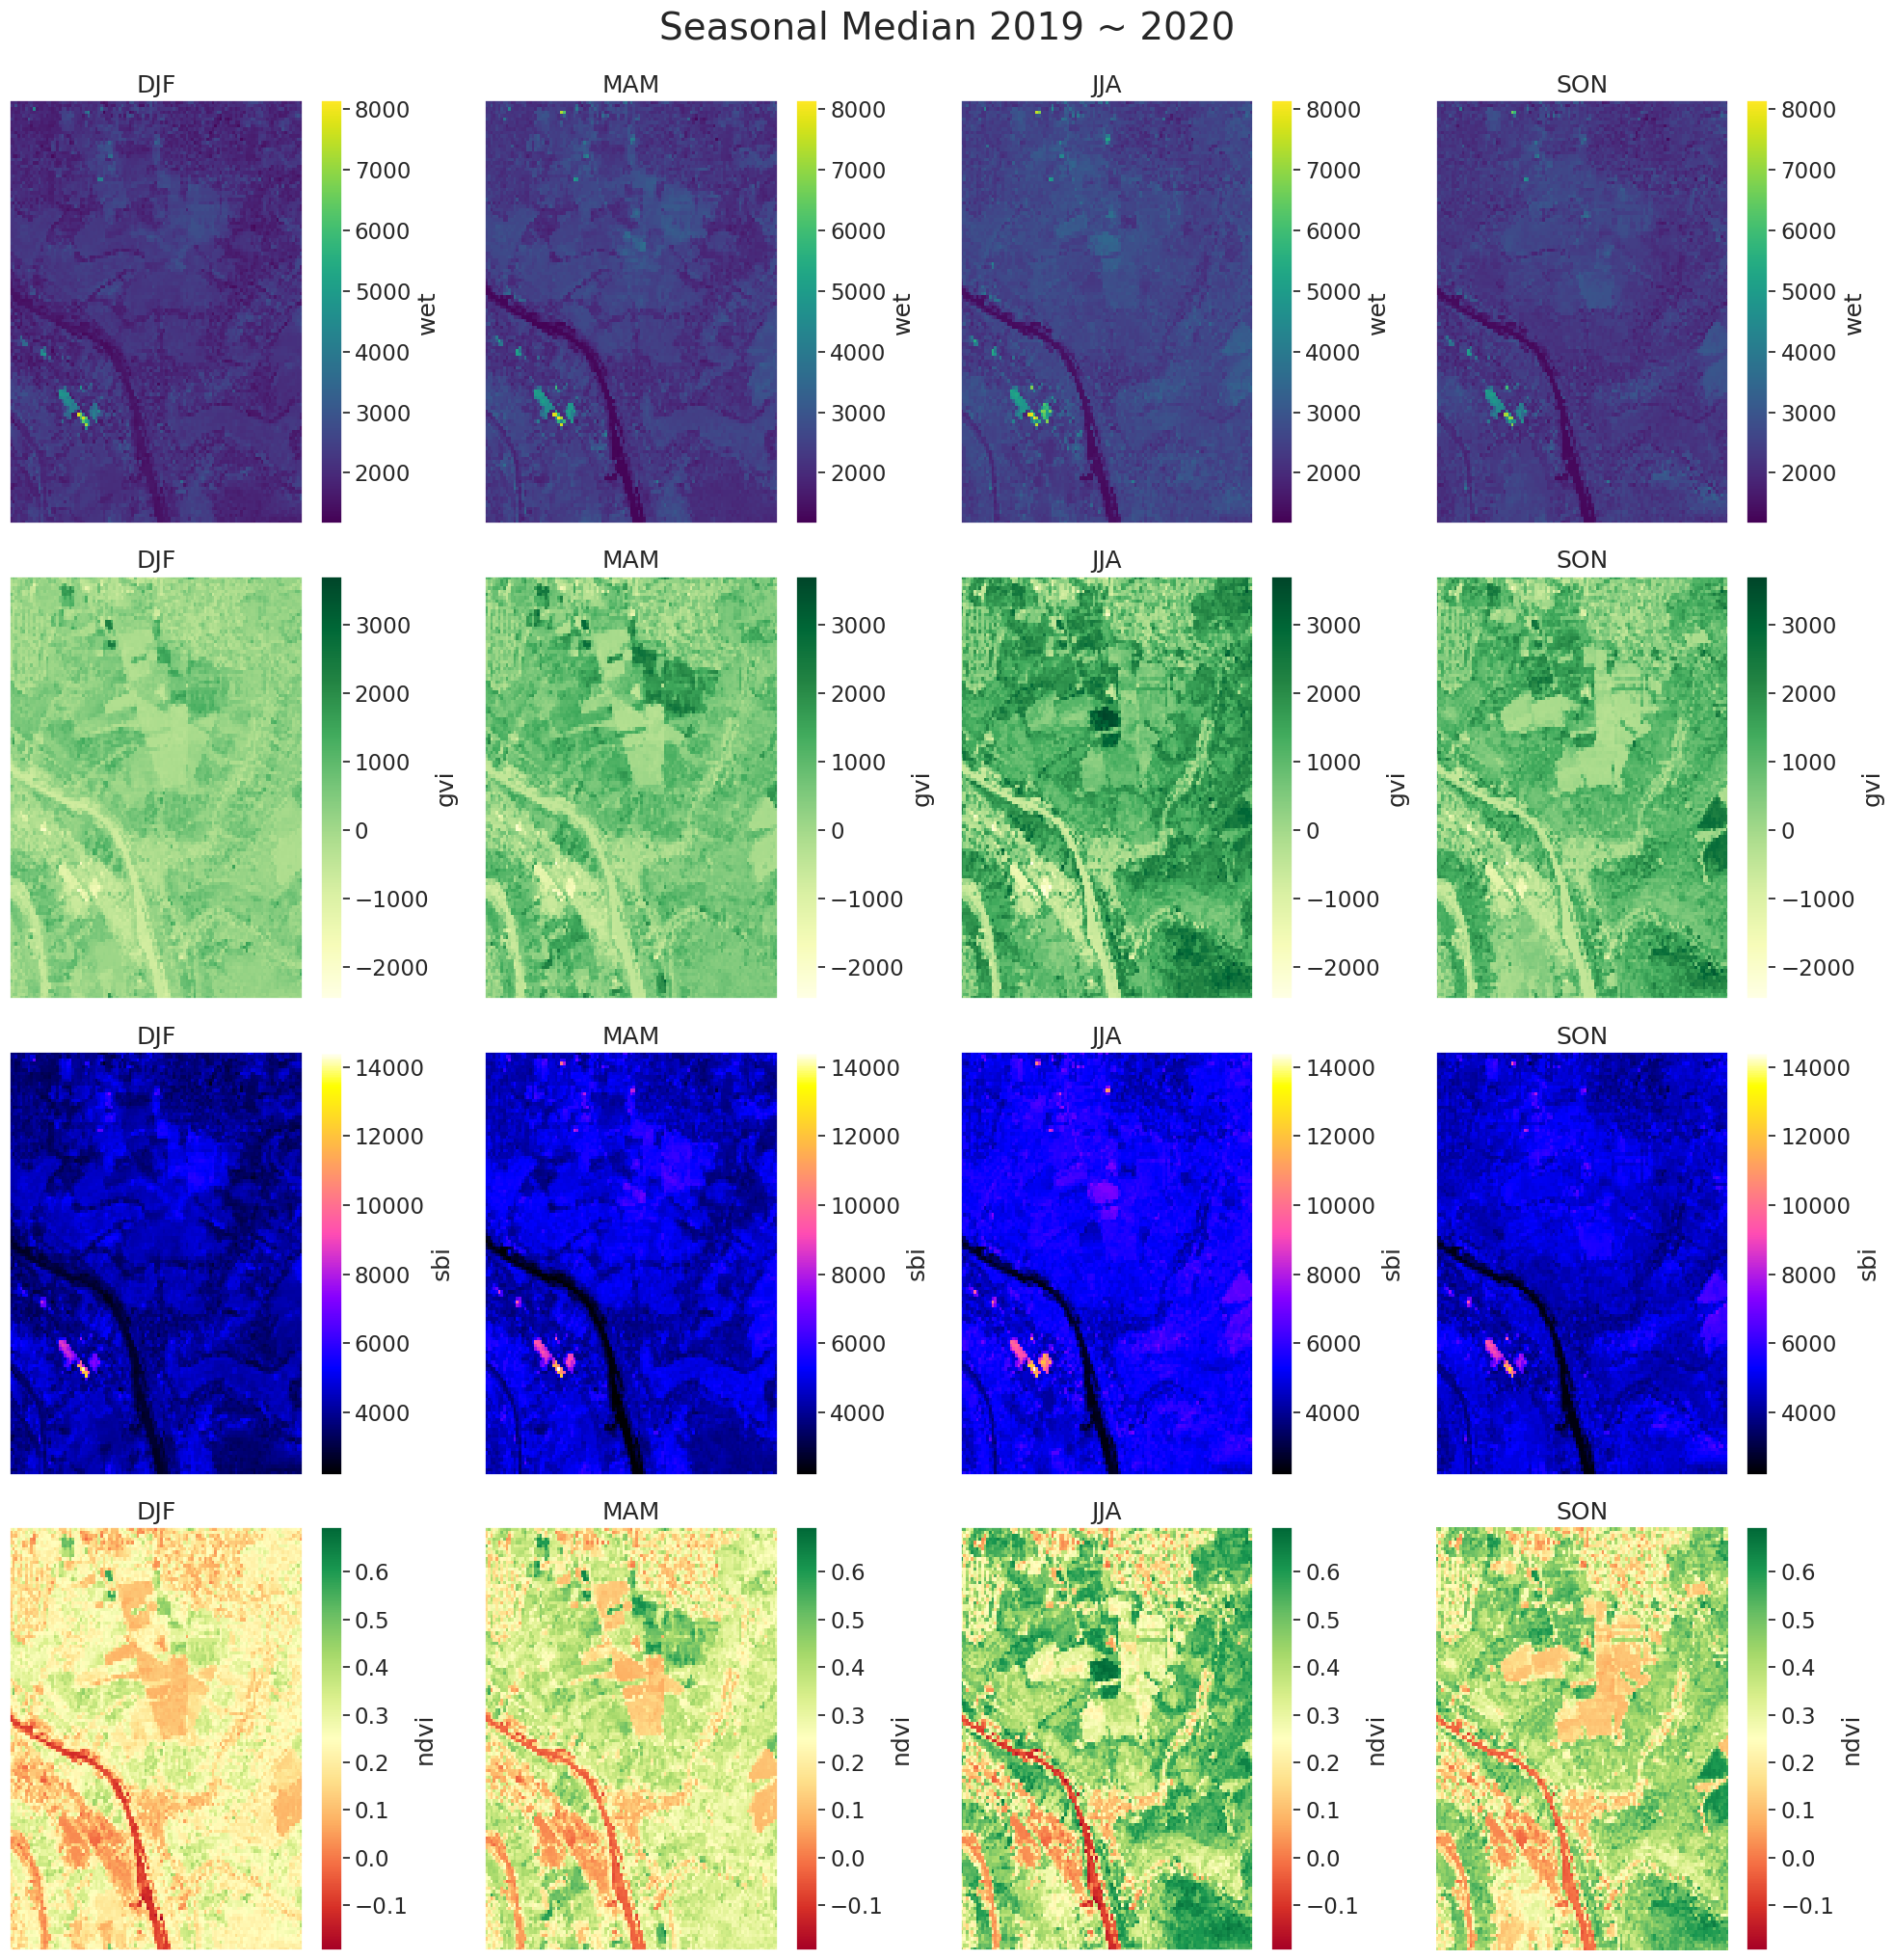

In [26]:
ds_input = ds_grp # Define the dataset to be plotted
mylist = ["DJF", "MAM", "JJA", "SON"] #arrange seasons into our list
c = ['viridis','YlGn','gnuplot2','RdYlGn'] #the list of color maps

sns.set(font_scale=1.5) #scale the texts in plot to 1.5
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20,20)) #plot subplots

for i, sea in enumerate(mylist):
    ds_input['wet'].sel(season=sea).plot(ax=axes[0,i], vmin=wet.min(), vmax=wet.max(), cmap=c[0], robust=True)                                      
    ds_input['gvi'].sel(season=sea).plot(ax=axes[1,i], vmin=gvi.min(), vmax=gvi.max(), cmap=c[1], robust=True)
    ds_input['sbi'].sel(season=sea).plot(ax=axes[2,i], vmin=sbi.min(), vmax=sbi.max(), cmap=c[2], robust=True)
    ds_input['ndvi'].sel(season=sea).plot(ax=axes[3,i], vmin=ndvi.min(), vmax=ndvi.max(), cmap=c[3], robust=True)
    
for i, ax in enumerate(axes.flatten()):
    ax.set_title(mylist[i%4]) #plot subtitles
    
for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([]) #empty x ticks
    ax.axes.get_yaxis().set_ticklabels([]) #empty y ticks
    ax.set_xlabel('') #empty x label
    ax.set_ylabel('') #empty y label
    
plt.axis("off") #remove all axis
plt.tight_layout() #adjust excessive padding
fig.suptitle('Seasonal Median 2019 ~ 2020', fontsize=28, y=1.02) #main plot title

***Tip:***
* ***You may find the codes for individual color maps at [this site](https://matplotlib.org/stable/tutorials/colors/colormaps.html).***
* ***To learn more about plotting, you could refer to [this](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/06_plotting_basics.ipynb) and [this](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/IV_advanced_plotting.ipynb) notebooks in our training series.***

### Plot Zonal Statistics of Time Series

After plotting the indices for each season, we can see some seasonal differences. Nevertheless, it would be helpful if we could quantify them in the time series analysis. We can achieve it by getting the average value for the whole area. Below we define a function that takes the average for all indices and generates a new pandas Dataframe.

In [27]:
df_all = pd.DataFrame()
for i in ["wet", 'gvi', 'sbi', 'ndvi']:
    df_new = ds_grp[i].median(axis=(1,2)).to_dataframe().drop(columns=['spatial_ref'])
    df_all = pd.concat([df_all, df_new], axis=1)
df_all

,wet,gvi,sbi,ndvi
season,,,,
DJF,2123.850586,188.068253,4084.601562,0.218977
JJA,2579.711914,1233.334961,5236.437012,0.427579
MAM,2353.835449,579.929993,4609.074219,0.309796
SON,2304.593994,866.876892,4595.886719,0.385743


Let's apply this function to ds_clip and get our new Dataframe.

This 4*4 new pandas Dataframe allows us to do plotting for the whole year. We can plot it using `plot()` after setting the style with `seaborn`

Text(0.5, 1.0, 'Tasseled Cap Indices for 2019-12 to 2020-11')

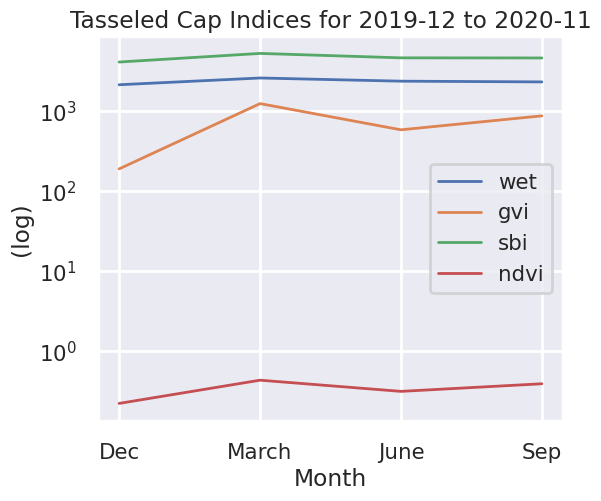

In [28]:
# define figure style
sns.set_style('darkgrid')
sns.set_context("poster", font_scale = .7)

# plot
ax = df_all.plot(figsize=[6,5], linewidth=2)

# layout
ax.set_yscale('log')
plt.ylabel("(log)")
plt.xlabel("Month")
plt.xticks([0, 1, 2, 3], ['Dec', 'March', 'June', 'Sep']) 
plt.title("Tasseled Cap Indices for 2019-12 to 2020-11")

***

## Additional information

<font size="2">This notebook is provided for teaching by the [Department of Remote Sensing](http://remote-sensing.org/), [University of Wuerzburg](https://www.uni-wuerzburg.de/startseite/). It has been updated to use Planetary Computer STAC + `odc-stac`. </font>

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0).

**Data access:** Sentinel-2 L2A pixels are loaded from the Microsoft Planetary Computer via STAC using `odc-stac`.

**Data license:** See the dataset/collection metadata on Planetary Computer for license and attribution details.

**Contact:** If you would like to report an issue with this notebook, you can file one on [GitHub](https://github.com).

**Last modified:** January 2023